## REGISTRATION AND TRACKING OF POINTER IN CT SCAN






In [1]:
import numpy as np

from matplotlib import pyplot as plt
import sksurgerycore.algorithms.procrustes as pro
import sksurgerycore.transforms.matrix as mu


In [2]:
def centre_transform(T, origin):
    T1 = np.eye(4)
    T1[0:3,3]= np.array(origin) # translation of origin to centre of image
    T2 = np.linalg.inv(T1) # inverse translation back to origina location

    centred_transform = np.dot(T1, np.dot( T , T2 ))
    centred_transform[0:3, 3] += T[0:3, 3]
    return centred_transform

def get_transform(T, origin):

    THom = np.eye(4)

    THom[0,3] = T[0]
    THom[1,3] = T[1]
    THom[2,3] = T[2]

    # defining rotation in x
    theta_x = T[3] * np.pi /180
    rotX = np.eye(4)
    if theta_x != 0:
        rotX[1, 1] = np.cos(theta_x)
        rotX[2, 2] = np.cos(theta_x)
        rotX[2, 1] = np.sin(theta_x)
        rotX[1, 2] = -np.sin(theta_x)

    # defining rotation in y
    theta_y = T[4] * np.pi /180
    rotY = np.eye(4)
    if theta_y != 0:
        rotY[0, 0] = np.cos(theta_y)
        rotY[2, 2] = np.cos(theta_y)
        rotY[0, 2] = np.sin(theta_y)
        rotY[2, 0] = -np.sin(theta_y)

    # defining rotation in z
    theta_z = T[5] * np.pi /180
    rotZ = np.eye(4)
    if theta_z != 0:
        rotZ[0, 0] = np.cos(theta_z  )
        rotZ[1, 1] = np.cos(theta_z )
        rotZ[1, 0] = np.sin(theta_z )
        rotZ[0, 1] = -np.sin(theta_z )

    # combining rotation matrices with translation to rotate around centre
    rotations = centre_transform(rotX @ rotY @ rotZ, origin)

    # scaling
    S = np.eye(4)
    if len(T)==7:
        # making 3 values at diagonals scale factor
        S = S * T[6]
        S[-1,-1] = 1
        S = centre_transform(S, origin)

    # multiplying all these matrices to get final transform
    THom = THom @ S @ rotations
    return THom

![img](./images/pointer_setup.png)

In the above image, we can see the general setup involved in the surgery when using a pointer. The goal is to be able to display the pointer in image coordinates as we can see in the image below:

![pointer on MRI](./images/MRI_pointer.png)

The goal is therefore turning the pointer's coordinates to MRI coordinates.

X<sub>MRI</sub> = T X<sub>PntEnd</sub>

where T are the transformations involved in turning from the pointer's point to the MRI coordinates. These transformations are the following:

T = <sup>MRI</sup>T<sub>PatRef</sub> * 
    <sup>PatRef</sup>T<sub>Cam</sub>  * 
    <sup>Cam</sup>T<sub>PntRef</sub> * 
    <sup>PntRef</sup>T<sub>endP</sub>
    
In the following sections we will go step by step on how to go from each of these transforms

Here is an image with all the transforms:

![pointer setup with transforms](./images/pointer_setup_transforms.png)

# ASSUMPTIONS / SETUP

1. Cancer, patient reference, pointer reference are all aligned in z direction (have same z coordinate) and are facing the camera straight on so that the distance is D

2. Patient reference is at a set distance Yc from the cancer but aligned in the X direction

3. pointer is touching the cancer, so the pointer and cancer have the same coordinates

4. Length of pointer is known

5. Angle of pointer is known

![pointer assumptions from sagittal view](./images/pointer_setup_assumptions_sagittal.png)
![pointer assumptions from transverse view](./images/pointer_setup_assumptions_transverse.png)

In [3]:
# ALL MEASUREMENTS IN MM

# P - length from tip of pointer to reference of pointer
pointer_length = 100

# D - z distance from camera to plane where everything is located
distance_from_cam = 1000 # since the camera and patient reference are aligned in the x and y directions, only distance is in z

# 0 - angle of pointer
pointer_angle = 45

# Yc- distances from cancer to patient reference
cancer_patref_y = 50  # Yc
# Zc and Yc would be 0 as the patient reference and cancer are aligned

# 1. Point reference to camera coordinates

Here is an image of the pointer with its reference:

![pointer image](./images/pointer_image.png)
![pointer image](./images/pointer_geometry.png)

In our case, let us assume we already know what the length of the pointer is.

In [4]:
print(f'pointer length is: {pointer_length}mm' )

pointer length is: 100mm


Original pointer reference coordinates

[[  0.   0.   0.]
 [  0.   0.  50.]
 [  0.  25. 100.]
 [  0. -25. 135.]]


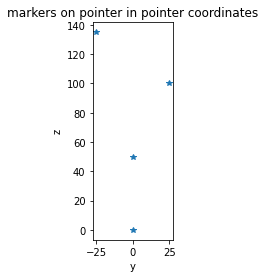

In [5]:
# pointer reference (from datasheet)
pnt_ref =  np.zeros((4, 3))
pnt_ref[1][2] = 50
pnt_ref[2][1] = 25
pnt_ref[2][2] = 100
pnt_ref[3][1] = -25
pnt_ref[3][2] = 135
print(pnt_ref)

# plotting original points
plt.figure()
plt.plot(pnt_ref[:,1],pnt_ref[:,2], marker='*',linestyle = 'None',)
plt.title('markers on pointer in pointer coordinates')
plt.xlabel('y')
plt.ylabel('z')
plt.gca().set_aspect('equal', adjustable='box')

plt.show()


TRANSFORMING POINTER COORDS FROM POINTER END

[[  0.   0. 100.]
 [  0.   0. 150.]
 [  0.  25. 200.]
 [  0. -25. 235.]]


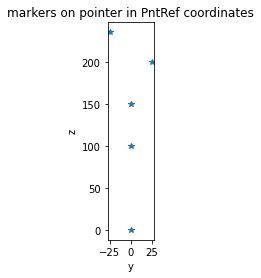

In [6]:
# adding pointer length to each coords in z direction
pnt_ref_transformed = np.copy(pnt_ref)
pnt_ref_transformed[:,2]+=pointer_length
print(pnt_ref_transformed)

# adding pointer end to matrix of pointer coords to better visualise on a plot
pnt_tip = np.array([[0,0,0]])
pnt_ref_with_tip = np.concatenate((pnt_ref_transformed, pnt_tip), axis=0)

plt.figure()
plt.plot(pnt_ref_with_tip[:,1],pnt_ref_with_tip[:,2], marker='*',linestyle = 'None',)
plt.title('markers on pointer in PntRef coordinates')
plt.xlabel('y')
plt.ylabel('z')
plt.gca().set_aspect('equal', adjustable='box')

plt.show()

## Here is now the transformation between the pointer's tip coordinates to the marker coordinates (<sup>pntRef</sup> T <sub>endP</sub>)

In [7]:
# getting the transformation from pointer's end coordinates to marker coordinates
R_endP_endRef, t_endP_endRef, FRE_endP_endRef = pro.orthogonal_procrustes(pnt_ref, pnt_ref_transformed)
print(R_endP_endRef) # should be no rotation
print(t_endP_endRef) # should be a translation of the length of the pinter in the z direction
print(FRE_endP_endRef)

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00 -4.16333634e-17]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 0.00000000e+00]
 [ 7.12971349e-15]
 [-1.00000000e+02]]
7.485857825702899e-15


# 2. MARKER'S COORDINATES TO CAMERA COORDINATES

GENERATING 3D ROTATION

[[ 1.          0.          0.          0.        ]
 [ 0.          0.70710678 -0.70710678  0.        ]
 [ 0.          0.70710678  0.70710678  0.        ]]
[[  0.   0. 100.]
 [  0.   0. 150.]
 [  0.  25. 200.]
 [  0. -25. 235.]]
[[   0.          -70.71067812   70.71067812    0.        ]
 [   0.         -106.06601718  106.06601718    0.        ]
 [   0.         -123.74368671  159.09902577    0.        ]
 [   0.         -183.84776311  148.49242405    0.        ]]


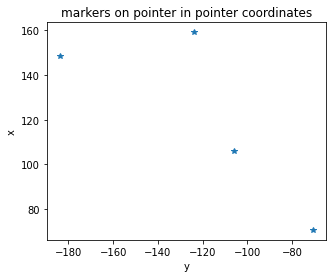

In [8]:
# setting transform and origin of rotation
T = [0,0,0,45,0,0] #([Tx, Ty, Tz, Rx, Ry, Rz])
origin = [0, 0 , 0]

# getting homogenous transformation
THom = get_transform(T,origin)
print(THom[:3, :])
print(pnt_ref_transformed)

# transforming with this transform
transformed_pointer = (THom[:,:3] @ pnt_ref_transformed.T).T
print(transformed_pointer)

# plotting result

plt.figure()
plt.plot(transformed_pointer[:,1],transformed_pointer[:,2], marker='*',linestyle = 'None',)
plt.title('markers on pointer in pointer coordinates')
plt.xlabel('y')
plt.ylabel('x')
plt.gca().set_aspect('equal', adjustable='box')

plt.show()

TRANDFORMING TO CAMERA COORDINATES

In [9]:
# turning z axis to D
transformed_pointer[0:4,3] = distance_from_cam
print(transformed_pointer)

[[   0.          -70.71067812   70.71067812 1000.        ]
 [   0.         -106.06601718  106.06601718 1000.        ]
 [   0.         -123.74368671  159.09902577 1000.        ]
 [   0.         -183.84776311  148.49242405 1000.        ]]


### Now getting pointer reference point in camera coordinates <sup>Cam</sup>T<sub>PntRef</sub>

In [10]:
# getting the transformation from pointer's marker coords to camera coordinates

R_endRef_cam, t_endRef_cam, FRE_endRef_cam = pro.orthogonal_procrustes(pnt_ref_transformed , transformed_pointer[:,1:])
print(R_endRef_cam)
print(t_endRef_cam)
print(FRE_endRef_cam)

[[ 0.          0.          1.        ]
 [ 0.70710678  0.70710678  0.        ]
 [-0.70710678  0.70710678  0.        ]]
[[-1.00000000e+03]
 [-1.42108547e-14]
 [ 8.52651283e-14]]
2.6822400070865448e-14


# 2. CT TO WORLD COORDINATES

In order to convert CT coordinates to camera coordinates, we typically would take the marker and move it over the surface of the patient's head. We then use an ICP algorithm to match the two surfaces- of the points on the face and those on the CT.

We assume however for the purpose of this simulation that we know the transformation from the CT to camera coordinates. We assume the CT scan coordinates are translated by a certain amount from the patient coordinates.

![MRI to camera coordinates](./images/3D_to_cam.png)

In [33]:
# average head dimensions from: https://en.wikipedia.org/wiki/Human_head
x = 10 # head length (about 20)
y = 13 # menton to top of head (about 25)
z = -8 # head bredth (about 15)
translations = [-x,-y,z, 0, 0, 0]
cam_to_MRI = get_transform(translations, origin)
print(cam_to_MRI)

[[  1.   0.   0. -10.]
 [  0.   1.   0. -13.]
 [  0.   0.   1.  -8.]
 [  0.   0.   0.   1.]]


### Getting camera to MRI transform <sup>MRI</sup>T<sub>Cam</sub>

In [44]:
R_cam_MRI = cam_to_MRI[:3,:3]
t_cam_MRI = np.array([cam_to_MRI[:3,3]]).T
print(R_cam_MRI)
print(t_cam_MRI)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[-10.]
 [-13.]
 [ -8.]]


In [67]:
point_in_cam = np.array([[0,0,distance_from_cam]])
print(point_in_cam)
point_in_MRI = ((R_cam_MRI@point_in_cam.T) + t_cam_MRI).T
print(point_in_MRI)

[[   0    0 1000]]
[[-10. -13. 992.]]


# to complete the whole transformation


In [59]:
# we start with a point in pointer's end coordinates- eg. the cancer is touching the pointer's end
cancer_pointer = np.array([[0,0,0]])
cancer_pointer

array([[0, 0, 0]])

In [60]:
# go to pointer's marker coords
cancer_marker = ((R_endP_endRef@cancer_pointer.T) + t_endP_endRef).T
print(cancer_marker)

[[ 0.00000000e+00  7.12971349e-15 -1.00000000e+02]]


In [61]:
# now from marker to world
cancer_world = (np.matmul(R_endRef_cam, np.transpose(cancer_marker)) + t_endRef_cam).T
print(cancer_world)

[[-1.10000000e+03 -9.16938596e-15  9.03065970e-14]]


In [65]:
# finally from world to ct
#pointer_CT = (np.matmul(ct_to_pat[:,:3], np.transpose(point_in_cam)) + t_cam_CT).T
#print(cancer_world)
#cancer_world_new = np.concatenate((cancer_world, np.array([[1]])), axis=1)
#cancer_CT = ct_to_pat@cancer_world_new.T 
#print(cancer_CT)

cancer_MRI = (np.matmul(R_cam_MRI, np.transpose(cancer_world)) + t_cam_MRI).T
cancer_MRI = cancer_MRI[0]


[-1110.   -13.    -8.]


In [69]:
print(cancer_MRI)
print(point_in_MRI)

[-1110.   -13.    -8.]
[[-10. -13. 992.]]


IndexError: index 1 is out of bounds for axis 0 with size 1

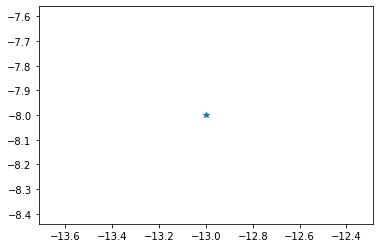

In [68]:
plt.plot(cancer_MRI[0], cancer_MRI[1], marker='*')
plt.plot(point_in_MRI[0], point_in_MRI[1], marker='^')
plt.xlabel('y')
plt.ylabel('z')
plt.show()

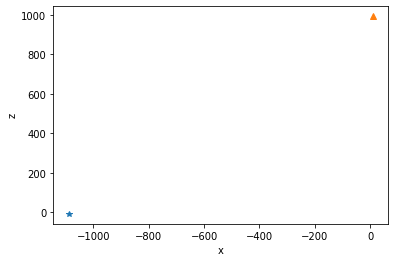

In [20]:
plt.plot(cancer_CT[0], cancer_CT[2], marker='*')
plt.plot(point_in_MRI[0], pointer_CT[2], marker='^')

plt.xlabel('x')
plt.ylabel('z')
plt.show()

# PATIENT REFERENCE

![real patient reference](./images/real_pat_ref.png)

![patient reference coordinates](./images/pointer_patref_marker.png)

In [21]:
# defining reference coordibates in ref coords
#A: x=0.00, y= 0.00, z=0.00 
#B: x=0.00, y= 28.59, z=41.02 
#C: x=0.00, y= 00.00, z=88.00 
#D: x=0.00, y=-44.32, z=40.45
    
# encoding the robot reference marker points into a numpy mattrix
pat_ref = np.zeros((4, 3)) 
pat_ref[1][1] = 28.59 
pat_ref[1][2] = 41.02 
pat_ref[2][2] = 88 
pat_ref[3][1] = -44.32 
pat_ref[3][2] = 40.45



TRANSFORMING PATIENT REFERENCE COORDINATES TO CAMERA COORDINATES

- we assume the patient reference centre is at the same level as the cancer and so the x coordinates are the same
- the distance in y direction between cancer and reference is known


![reminder of patient reference assumptions](./images/pat_ref_assumptions.png)

In [22]:
print(pat_ref)

[[  0.     0.     0.  ]
 [  0.    28.59  41.02]
 [  0.     0.    88.  ]
 [  0.   -44.32  40.45]]


marker points in camera coordinates:
[[  0.     0.     0.  ]
 [  0.    28.59  41.02]
 [  0.     0.    88.  ]
 [  0.   -44.32  40.45]]
[[   0.    -50.   1000.  ]
 [   0.    -21.41 1041.02]
 [   0.    -50.   1088.  ]
 [   0.    -94.32 1040.45]]


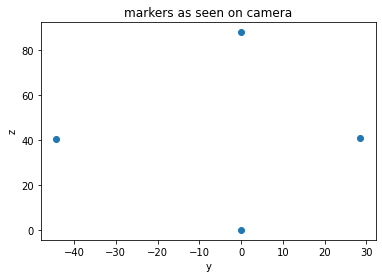

In [23]:
# Defining the 3 marker points in CT coordinates
image_points = np.zeros((4,3))
# position of markers along z axis is the same
z_offset = 200

pat_ref_cam = np.copy(pat_ref)
# x-axis stays as 0 for every point

# y-axis- adding Yc to all points in reference
pat_ref_cam[:,1] -= cancer_patref_y

#z-axis- adding to all points the distance D
pat_ref_cam[:,2] += distance_from_cam 

print('marker points in camera coordinates:') 
print(pat_ref)
print(pat_ref_cam)
# Draw them in 2D. Its a triangle.
plt.scatter(pat_ref[:,1],pat_ref[:,2] ) 
plt.xlabel('y')
plt.ylabel('z')
plt.title('markers as seen on camera')
plt.show()

DEFINING PATIENT REFERENCE COORDINATES ON CT

-typical sizes for x and y is 256 by 256

![](./images/CT_assumptions.png)

In [24]:
Y_cancer = 20
Y_cancer_ref = 100
Y_ref = 10

X_cancer_ref = 128 #(half-way through image)
X_ref = (0.5*72.91/0.5*88)*Y_ref # since the patient reference is rigid, the geometry needs to match

slice_num = 200

[[   128.     120.     200. ]
 [-64032.8    130.     200. ]
 [   128.     140.     200. ]
 [ 64288.8    130.     200. ]]


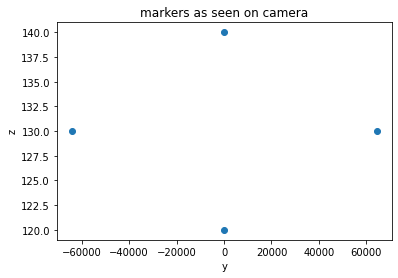

In [25]:
pat_ref_CT = np.zeros((4, 3)) 

# z of all markers is the same as they are in the same slice
pat_ref_CT[:,2] = 200

# this is the top marker (A)
pat_ref_CT[0,0] = X_cancer_ref # x
pat_ref_CT[0,1] = Y_cancer + Y_cancer_ref # y

# this is the left marker (B)
pat_ref_CT[1,0] = X_cancer_ref-X_ref # x
pat_ref_CT[1,1] = Y_cancer + Y_cancer_ref+Y_ref # y

# this is the bottom marker (C)
pat_ref_CT[2,0] = X_cancer_ref # x
pat_ref_CT[2,1] = Y_cancer + Y_cancer_ref + 2*Y_ref # y

# this is the right marker (D)
pat_ref_CT[3,0] = X_cancer_ref + X_ref # x
pat_ref_CT[3,1] = Y_cancer + Y_cancer_ref + Y_ref # y

print(pat_ref_CT) 

plt.scatter(pat_ref_CT[:,0],pat_ref_CT[:,1] ) 
plt.xlabel('y')
plt.ylabel('z')
plt.title('markers as seen on camera')
plt.show()

GETTING TRANSFORM FROM CAMERA COORDINATES -> CT COORDINATES


In [26]:
# getting transform to go from patient reference in camera to patient reference in CT coords
R_cam_CT, t_cam_CT, FRE_cam_CT = pro.orthogonal_procrustes(pat_ref_CT , pat_ref_cam )

# Print matrices.
print('')
print('transformation from patref in camera to CT coordinates') 
print("Rotation:" )
print(R_cam_CT)
print("Translation:" )
print(t_cam_CT)
print("FRE:")
print(FRE_cam_CT)


transformation from patref in camera to CT coordinates
Rotation:
[[-1.93879049e-22 -9.99969453e-01 -7.81614848e-03]
 [-1.31838984e-16 -7.81614848e-03  9.99969453e-01]
 [-1.00000000e+00 -2.22051390e-16  4.33682006e-16]]
Translation:
[[  82.2164466 ]
 [-912.75720369]
 [ 200.        ]]
FRE:
45342.76497464919


In [27]:
patref_in_CT_coordinates = (np.matmul(R_cam_CT, np.transpose(pat_ref_cam)) + t_cam_CT).T

In [28]:
print(pat_ref_CT)
print(patref_in_CT_coordinates)

[[   128.     120.     200. ]
 [-64032.8    130.     200. ]
 [   128.     140.     200. ]
 [ 64288.8    130.     200. ]]
[[124.3987708   87.60305718 200.        ]
 [ 95.48902571 128.39834047 200.        ]
 [123.71094973 175.60036908 200.        ]
 [168.40125377 128.39823327 200.        ]]


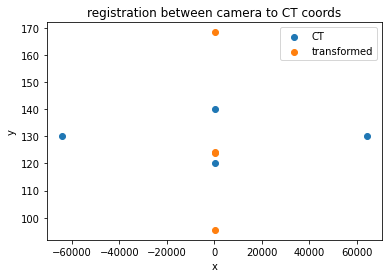

In [29]:
plt.figure()
plt.scatter(pat_ref_CT[:,0],pat_ref_CT[:,1], label='CT' ) 
plt.scatter(patref_in_CT_coordinates[:,1], patref_in_CT_coordinates[:,0] , label='transformed') 

plt.legend();
plt.xlabel('x')
plt.ylabel('y')
plt.title('registration between camera to CT coords')
plt.show()

# POINTER LOCATION IN CT COORDINATES

In [30]:
pointer_cam = np.zeros(3)
pointer_cam[2] = distance_from_cam
print(pointer_cam)

[   0.    0. 1000.]


In [31]:
pointer_CT = (np.matmul(R_cam_CT, np.transpose(pointer_cam)) + t_cam_CT).T